## HTTP Adapter Engineering

Urllib3 documnetation: https://urllib3.readthedocs.io/en/stable/reference/urllib3.util.html#urllib3.util.Retry

Requests Documnetation: https://docs.python-requests.org/en/latest/user/advanced/

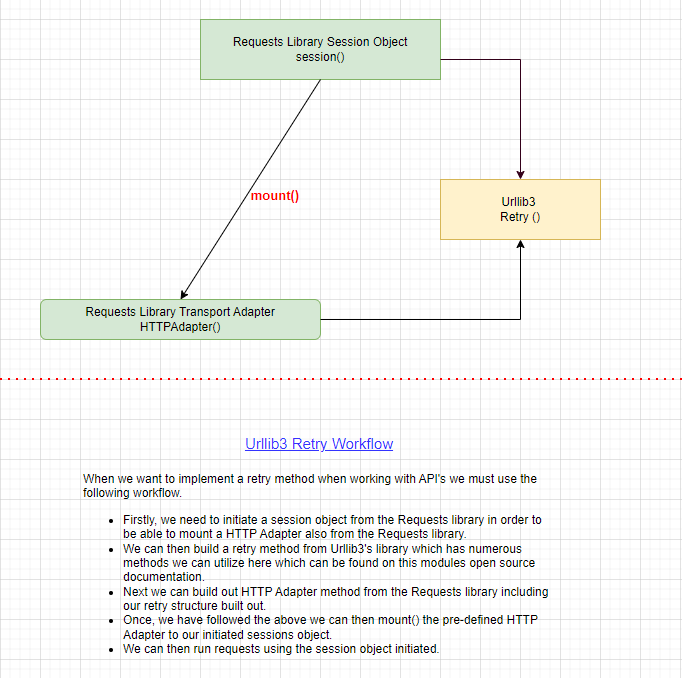

### Session Objects

The Session object allows you to persist certain parameters across requests. It also persists cookies across all requests made from the Session instance, and will use urllib3’s CONNECTION POOLING. So if you’re making several requests to the same host, the underlying TCP connection will be reused, which can result in a significant performance increase.

NOTE

A Session object has all the methods of the main Requests API.

### Automatic Retries

By default, Requests does not retry failed connections. However, it is possible to implement automatic retries with a powerful array of features, including backoff, within a Requests Session using the urllib3.util.

In [1]:
# import libraries
from urllib3.util import Retry
from requests import Session
from requests.adapters import HTTPAdapter

## Urllib3 Library

status
- How many times to retry on bad status codes. These are retries made on responses, where status code matches status_forcelist.

status_forcelist
- A set of integer HTTP status codes that we should force a retry on. A retry is initiated if the request method is in allowed_methods and the response status code is in status_forcelist. By default, this is disabled with None.

backoff_factor (float) –
- A backoff factor to apply (seconds) between attempts after the second try (most errors are resolved immediately by a second try without a delay). For example, if the backoff_factor is 0.1, then Retry.sleep() will sleep for [0.0s, 0.2s, 0.4s, 0.8s, …] between retries. No backoff will ever be longer than backoff_max. By default, backoff is disabled (factor set to 0).

redirect (int) –
- How many redirects to perform. Limit this to avoid infinite redirect loops. A redirect is a HTTP response with a status code 301, 302, 303, 307 or 308. Set to 0 to fail on the first retry of this type. Set to False to disable and imply raise_on_redirect=False.

allowed_methods (Collection) –
- Set of uppercased HTTP method verbs that we should retry on. By default, we only retry on methods which are considered to be idempotent (multiple requests with the same parameters end with the same state). See Retry.DEFAULT_ALLOWED_METHODS. Set to a None value to retry on any verb.

In [2]:
# public facing endpoint for testimg
url = "https://api.coindesk.com/v1/bpi/currentprice.json"

We need to initiate Requests Session object to mount a HTTP Adapter. We cannot pre-define or utilize retry method from Urllib3 libray without initiating a sessions objects from the Requests library and mounting a HTTP Adapter.

In [3]:
# timeout parameters
time = (0.05,0.05) # connect read parameter arguments (float) seconds

# initiate urllib3 http retry settings
retries = Retry(
    total=3, # total retries
    backoff_factor=1, # backoff factor to apply (seconds) between attempts after the second try (most errors are resolved immediately by a second try without a delay)
    status_forcelist=[502, 503, 504], # set of integer HTTP status codes that we should force a retry on
    raise_on_redirect=False,
)

In [4]:
session = Session() # initiate Requests session object which use urllib3’s connection pooling
session.mount(url, HTTPAdapter(max_retries=retries)) # mount() registers specific instance of a Transport Adapter to a prefix

#
response = session.get(url,timeout=time)
data = response.json()

In [5]:
data

{'time': {'updated': 'Feb 14, 2024 13:13:46 UTC',
  'updatedISO': '2024-02-14T13:13:46+00:00',
  'updateduk': 'Feb 14, 2024 at 13:13 GMT'},
 'disclaimer': 'This data was produced from the CoinDesk Bitcoin Price Index (USD). Non-USD currency data converted using hourly conversion rate from openexchangerates.org',
 'chartName': 'Bitcoin',
 'bpi': {'USD': {'code': 'USD',
   'symbol': '&#36;',
   'rate': '51,536.044',
   'description': 'United States Dollar',
   'rate_float': 51536.0441},
  'GBP': {'code': 'GBP',
   'symbol': '&pound;',
   'rate': '41,055.932',
   'description': 'British Pound Sterling',
   'rate_float': 41055.9319},
  'EUR': {'code': 'EUR',
   'symbol': '&euro;',
   'rate': '48,138.634',
   'description': 'Euro',
   'rate_float': 48138.6335}}}

CONCLUSION

We can clearly see the workflow in the diagram added above. However, whats unclear is if some method override pre-defined settings in our Urllib3 retry method built out. 

For example. status_forcelist
- Using a status_forcelist form Urllib3's library in our Retry method attached to our HTTP Adapter which is mounted to our session object is unclear if this overrides the total retry value. To reference the defintion on Urllib3's "A set of integer HTTP status codes that we should force a retry on. A retry is initiated if the request method is in allowed_methods and the response status code is in status_forcelist." 
- What is not clear is if we do not define the allowed_methods(collection) method in our Retry method will inputing and passing a collection (set of integers) into our status_forcelist=[] be invalid.

Metaphorically what has superioirty against one and other here. Further research, testing analysis is required on that end.

Also, we need to find and enpoint or mechanism that will enable us to test the retry method built out being used. Ideally we need an endpoint which will fail on a set number of try's to evaluate and confirm testing. This also requires further research to work around this problem.
